<a href="https://colab.research.google.com/github/Manoj15/Explore-LLM/blob/main/LLM_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

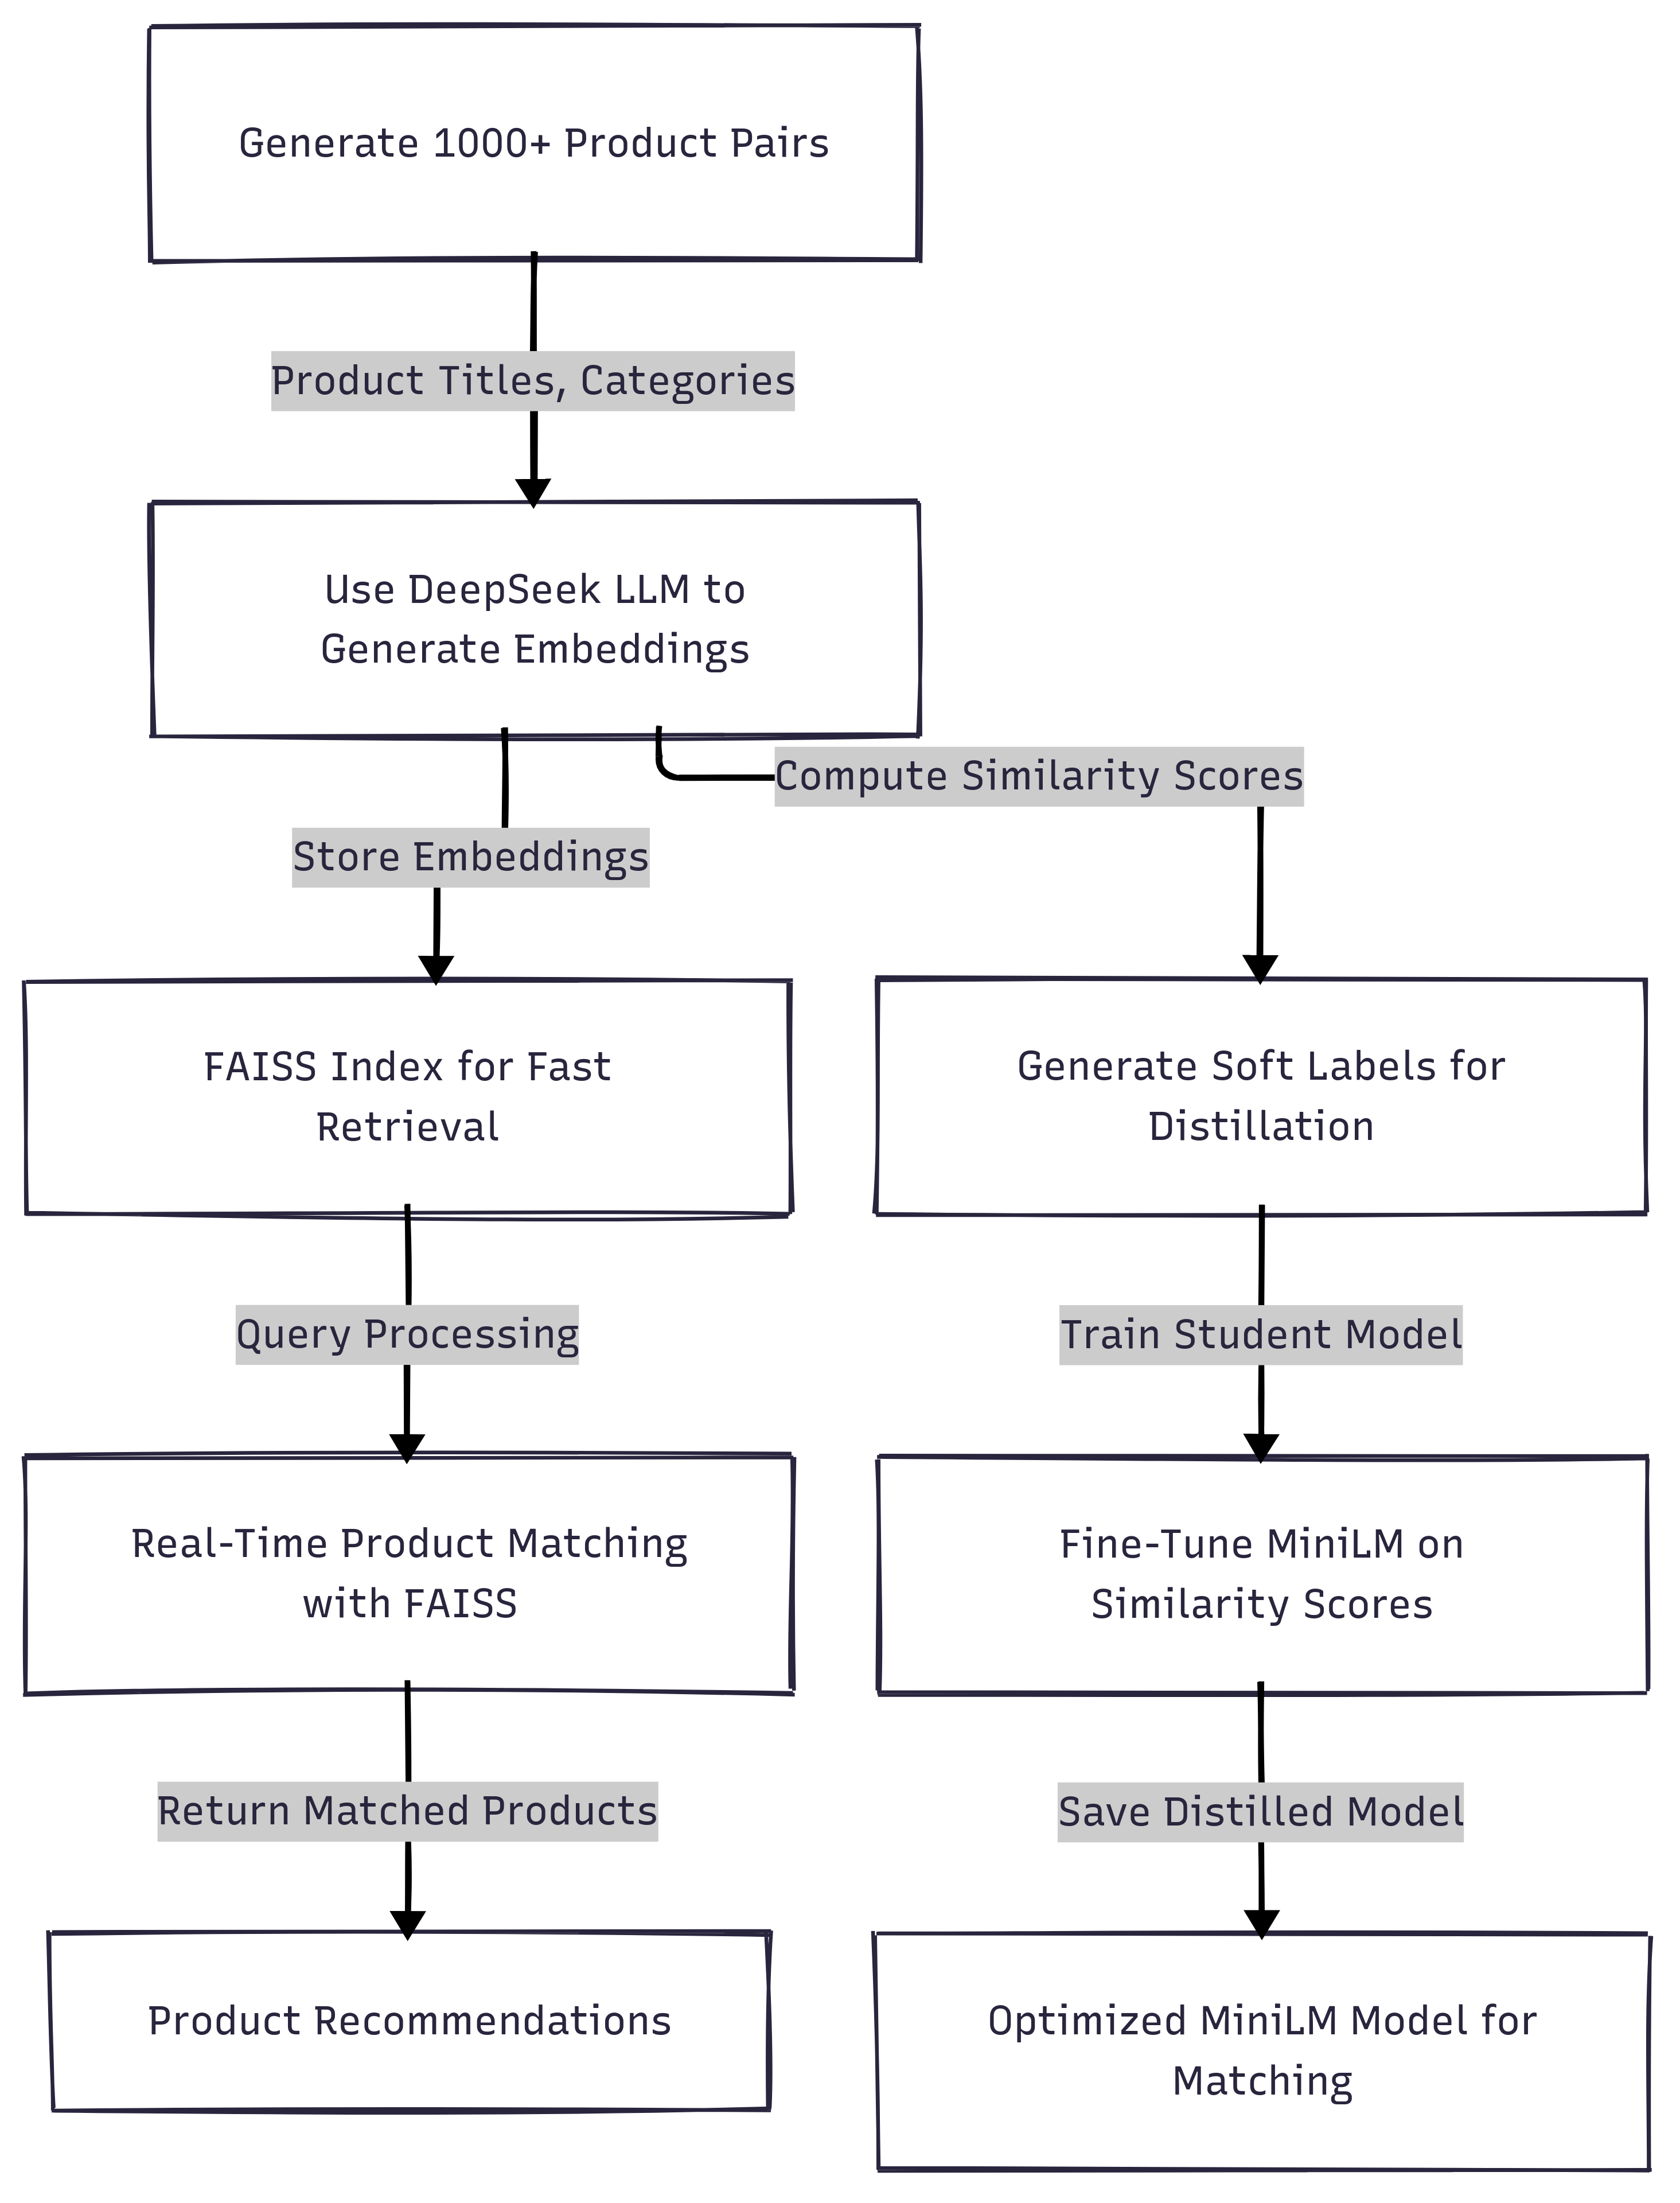

In [ ]:
!pip install transformers datasets faiss-cpu torch sentence-transformers scikit-learn


In [ ]:
import random
import pandas as pd

# Define product categories
categories = ["Electronics", "Footwear", "Fashion", "Home Appliances", "Sports", "Books"]

# Sample product templates
product_templates = {
    "Electronics": ["Apple iPhone 13", "Samsung Galaxy S22", "Sony 55-inch OLED TV", "Dell XPS 13 Laptop"],
    "Footwear": ["Nike Air Max Shoes", "Adidas Ultraboost", "Puma Running Shoes", "Reebok Sneakers"],
    "Fashion": ["Levi’s Denim Jacket", "Gucci Leather Belt", "Ray-Ban Aviator Sunglasses", "Nike Dri-Fit T-shirt"],
    "Home Appliances": ["Dyson Vacuum Cleaner", "Instant Pot Pressure Cooker", "Samsung Refrigerator", "LG Washing Machine"],
    "Sports": ["Wilson Tennis Racket", "Yonex Badminton Shuttle", "Spalding Basketball", "Nike Football Shoes"],
    "Books": ["Atomic Habits by James Clear", "Harry Potter Hardcover Set", "Deep Learning with Python", "Sapiens by Yuval Harari"],
}

# Generate 1000 product pairs
num_samples = 1000
product_data = []

for _ in range(num_samples):
    category = random.choice(categories)
    product_1 = random.choice(product_templates[category])
    product_2 = random.choice(product_templates[category])  # Pick a related product
    product_data.append((product_1, product_2, category))

print(f"Generated {len(product_data)} product pairs.")


In [ ]:
from huggingface_hub import login, notebook_login

# For notebook-based login (with a widget)
notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load DeepSeek LLM
model_name = "deepseek-ai/deepseek-llm-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
teacher_model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = teacher_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean pooling

# Create FAISS index for product embeddings
dimension = 4096  # Adjust based on DeepSeek embedding size
faiss_index = faiss.IndexFlatL2(dimension)

# Store product embeddings and compute similarity scores
product_embeddings = []
product_titles = []
similarity_scores = []

for product_1, product_2, _ in product_data:
    emb1 = get_embedding(product_1)
    emb2 = get_embedding(product_2)

    # Compute cosine similarity
    similarity = cosine_similarity(emb1, emb2)[0][0]
    similarity_scores.append(similarity)

    # Store embeddings in FAISS
    faiss_index.add(np.array([emb1, emb2], dtype=np.float32))

    # Save product titles for lookup
    product_titles.extend([product_1, product_2])

print(f"Stored {len(product_titles)} product embeddings in FAISS.")


In [ ]:
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader

# Load Student Model
student_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Convert Data to Training Format using real similarity scores
train_examples = [
    InputExample(texts=[p1, p2], label=similarity_scores[i])
    for i, (p1, p2, _) in enumerate(product_data)
]

# Define Training Parameters
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(student_model)

# Train the Model
student_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=100)
student_model.save("distilled_product_matching_model")

print("Student model trained successfully!")


In [ ]:
# Encode search query
query = "Nike running shoes"
query_vector = get_embedding(query)

# Search in FAISS
_, indices = faiss_index.search(np.array(query_vector, dtype=np.float32), k=5)

# Print matching product names
for idx in indices[0]:
    print(f"Matched Product: {product_titles[idx]}")
